In [1]:
from matplotlib.pyplot import *
import numpy as np
from matplotlib import *
import h5py
from matplotlib import cm
from tqdm import tqdm
import pandas as pd
import sklearn
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter

# a. Useful Functions

In [2]:
def read_data_map(file,remove_baseline=False):

    hf = h5py.File(file, 'r')
    sample = file.split("\\")[-1]
    keys = [key for key in hf.keys()]
    sample = keys[0].split(' ')[-1]

    spectrums = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['Shot_0']['Pro']))) for i in range(0, #Pro sem baseline, raw com baseline
                                                        len(list(hf['Sample_ID: ' + sample])))])
    positions = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['position']))) for i in range(0,
                                                        len(list(hf['Sample_ID: ' + sample])))])
    wavelengths = np.array(hf['System properties']['wavelengths'])
    
    unique_x = np.unique(positions[:,0])
    unique_y = np.unique(positions[:,1])
    
    nx = len(unique_x)
    ny = len(unique_y)
    indexes = np.lexsort((positions[:,0],positions[:,1]))
    spectrums = spectrums[indexes,:]
    spectrums = np.array(spectrums.reshape((ny,nx,-1)))
    print(spectrums.shape)
    positions = np.array(positions[indexes])
    
    hf.close()
    return spectrums, wavelengths, positions

def Raman_data_loader(filename):

    with h5py.File( filename, 'a') as output_file:
         
        properties = output_file['properties']
        
        exp_properties = {'step_size' : np.array(properties['step_size'])[0],
                          'speed' : np.array(properties['speed']),
                          'n_points' : np.array(properties['n_points'])
            }
        
        wavelengths = np.array(output_file['properties']['x_data'])
        
        
        spot_numbers = [int(s.split('_')[-1]) for s in list(output_file['data'].keys()) if 'spot' in s ]
        
        Nx,Ny = output_file['properties']['n_points'][0], output_file['properties']['n_points'][1]
        Nl = len(wavelengths)
        spectral_signal = np.zeros([Nx,Ny,Nl])
        
        
        for _i, spot_number in enumerate(spot_numbers):

            ix, iy = int(spot_number//Ny), int(spot_number%Ny)
            
            spot = 'spot_'+str(spot_number)
            data = np.array(output_file['data'][spot]['raw_data'])
                      
            spectral_signal[ix,iy,:] = data
            

    return spectral_signal, wavelengths, exp_properties

In [3]:
find_index = lambda wavelenghts, w : np.argmin(np.abs(wavelenghts-w))

In [4]:
def gauss(x, sigma, val):
    return np.exp( - (x - val)**2 / (2 * sigma ** 2))

In [5]:
from scipy.ndimage import convolve

kernel = (1.0/256)*np.array([[1, 4, 6, 4, 1],[4, 16, 24, 16, 4],[6, 24, 36, 24, 6], [4, 16, 24, 16, 4],[1, 4, 6, 4, 1]])

def add_padding(data, x_pad, y_pad):
    return np.pad(data, ((0, 0), (x_pad , x_pad), (y_pad, y_pad)), mode = 'mean')

def downscale(image):
    image_blur = convolve(image, kernel, mode = 'constant')
    return image_blur[::2, ::2]  

def upscale(image):
    image_up = np.zeros((2*image.shape[0], 2*image.shape[1]))
    image_up[::2, ::2] = image
    return convolve(image_up, 4*kernel, mode = 'constant')

def laplacian_pyramid(image, layers):
    laplace_pyra = []
    for energy in range(image.shape[0]):
        im1 = image[energy]
        lap_pyra = []
        for layer in range(layers):
            down = downscale(im1)
            up = upscale(down)
            lap_pyra.append(im1 - up)
            im1 = down
        lap_pyra.append(down)
        laplace_pyra.append(lap_pyra)
    return np.array(laplace_pyra, dtype = object)

def gaussian_pyramid(mask, layers):
    gaussian_pyra = []
    for energy in range(mask.shape[0]):
        im1 = mask[energy]
        gauss_pyra = [im1]
        for layer in range(0, layers):
            im1 = downscale(im1)
            gauss_pyra.append(im1)
        gaussian_pyra.append(gauss_pyra)
    return np.array(gaussian_pyra, dtype = object)

def final_pyramid(L, G):
    laplacian_final = []
    for i in range(L.shape[1]):
        laplacian_final.append((L[0, i]*G[0, i] + L[1, i]*G[1, i] + L[2, i]*G[2, i]))
    return np.array(laplacian_final, dtype = object)

def get_image(final_pyramid):
    rev_pyramid = final_pyramid[::-1]
    im = rev_pyramid[0]
    for i in range(1, len(rev_pyramid)):
        im = upscale(im) + rev_pyramid[i]
    return im

# 1. Load LIBS Data for 3 Energies

In [6]:
fpath = "E:/Data/Data_LIBS/HDR/"
filename = ["rock2_340_map", "rock2_355_map", "rock2_370_map"]

spectrums = []
for fname in filename:
    spectrum, wavelengths, positions = read_data_map(fpath + fname)
    spectrums.append(spectrum)

(100, 110, 16384)
(100, 110, 16384)
(100, 110, 16384)


In [7]:
spectrums = np.array(spectrums)
wavelengths = wavelengths.flatten()

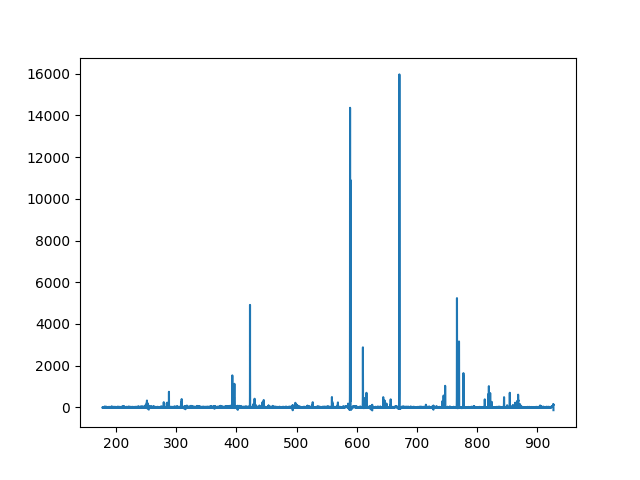

In [8]:
spec = 1 * spectrums[0, 25, 55, :]

%matplotlib widget
fig, ax = subplots()

ax.plot(wavelengths, spec)

In [9]:
pro_data = np.array(spectrums)

## 1.1 Normalize each spectrum to its sum 

In [10]:
pro_data_sum = np.array(pro_data)

for sp in range(pro_data_sum.shape[0]):
    spe = pro_data_sum[sp].reshape(pro_data_sum.shape[1]*pro_data_sum.shape[2], -1)
    norm = np.array([spe[i, :]/np.sum(spe[i, :]) for i in range(0, spe.shape[0])]).reshape(pro_data_sum.shape[1], pro_data_sum.shape[2], -1)
    print(norm.shape)
    pro_data_sum[sp] = norm

(100, 110, 16384)
(100, 110, 16384)
(100, 110, 16384)


## 1.2 Normalize each spectral image to [0-1] range | Gaussian smoothing

In [11]:
scaled_pro = []

sg = 0.75

for i in tqdm(range(0, pro_data_sum.shape[0])):
    # min_max_scaled = np.array([ (pro_data_sum[i, :, :, wv] - pro_data_sum[i].min())/(pro_data_sum[i].max() - pro_data_sum[i].min()) for wv in range(pro_data_sum.shape[-1])])
    min_max_scaled = np.zeros((pro_data_sum.shape[-1], pro_data_sum.shape[1], pro_data_sum.shape[2]))
    for wv in range(pro_data_sum.shape[-1]):
        gf = gaussian_filter(pro_data_sum[:, :, :, wv], axes = (1, 2), sigma = sg)
        min_max_scaled[wv] = (gf[i] - gf.min()) / (gf.max() - gf.min())
    scaled_pro.append(min_max_scaled)

scaled_pro = np.array(scaled_pro)

100%|██████████| 3/3 [02:16<00:00, 45.53s/it]


## 1.3 Find Translation to Assure proper alignment

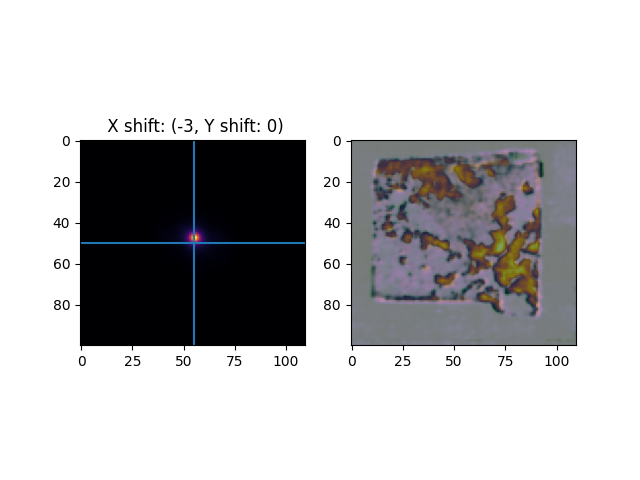

In [12]:
from scipy.signal import correlate

w_t = 819.4

im1 = scaled_pro[0, find_index(wavelengths, w_t)]
im2 = scaled_pro[2, find_index(wavelengths, w_t)]

translation = correlate(im1, im2, mode = 'same')**10

%matplotlib widget
fig, axs = subplots(1, 2)

cx = scaled_pro.shape[-2]//2
cy = scaled_pro.shape[-1]//2

shift_x = -(cx - np.where(translation == translation.max())[0][0])
shift_y = -(cy - np.where(translation == translation.max())[1][0])

ax = axs[0]
ax.set_title(f' X shift: ({shift_x}, ' 
             f'Y shift: {shift_y})')
ax.imshow(abs(translation), cmap = 'inferno')
ax.axhline(scaled_pro.shape[-2]//2)
ax.axvline(scaled_pro.shape[-1]//2)

ax = axs[1]
ax.imshow(im1, cmap = 'inferno')
ax.imshow(np.roll(im2, (shift_x, shift_y), axis = (0, 1)), alpha = 0.5, cmap = 'Greens', vmax = 0.2)

### 1.3.1 Set the transformation for all energies

In [13]:
for i in range(1, scaled_pro.shape[0]):
    im1 = scaled_pro[0, find_index(wavelengths, w_t)]
    im2 = scaled_pro[i, find_index(wavelengths, w_t)]

    translation = correlate(im1, im2, mode = 'same')**10

    cx = scaled_pro.shape[-2]//2
    cy = scaled_pro.shape[-1]//2

    shift_x = -(cx - np.where(translation == translation.max())[0][0])
    shift_y = -(cy - np.where(translation == translation.max())[1][0])
    scaled_pro[i] = np.roll(scaled_pro[i], (shift_x, shift_y), axis = (1, 2))

## 1.4 Find Rotation

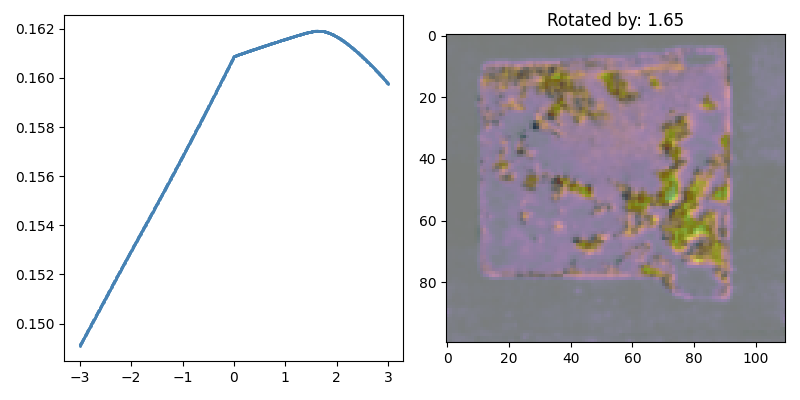

In [14]:
from scipy.signal import correlate
from skimage.transform import rotate

w_t = 819.4

im1 = scaled_pro[0, find_index(wavelengths, w_t)]
im2 = scaled_pro[2, find_index(wavelengths, w_t)]

max_angle = 3
rotation_angles = np.linspace(-max_angle, max_angle, 1000)
rot_coef = []

for i in rotation_angles:
    im2_rotated = rotate(im2, angle = i, resize = False)
    rot_coef.append( np.sum(im2_rotated*im1) / np.sqrt(np.sum(im2_rotated)**2 + np.sum(im1)**2))

angle_to_rot = rotation_angles[np.argmax(rot_coef)]

fig, axs = subplots(1, 2, figsize = (8, 4))

ax = axs[0]
ax.plot(rotation_angles, rot_coef, ls = '--', marker = 'o', color = 'steelblue', ms = 1)

ax = axs[1]
ax.set_title(f'Rotated by: {angle_to_rot:.2f}')
ax.imshow(im1, cmap = 'inferno')
ax.imshow(rotate(im2, angle = angle_to_rot, resize = False, order = 0), alpha = 0.5, cmap = 'Greens', vmax = 0.5)

fig.tight_layout()

### 1.4.1 Set Rotation for All images

In [15]:
for i in range(1, scaled_pro.shape[0]):
    im1 = scaled_pro[0, find_index(wavelengths, w_t)]
    im2 = scaled_pro[i, find_index(wavelengths, w_t)]

    max_angle = 3
    rotation_angles = np.linspace(-max_angle, max_angle, 1000)
    rot_coef = []

    for a in rotation_angles:
        im2_rotated = rotate(im2, angle = a, resize = False)
        rot_coef.append( np.sum(im2_rotated*im1) / np.sqrt(np.sum(im2_rotated)**2 + np.sum(im1)**2))

    angle_to_rot = rotation_angles[np.argmax(rot_coef)]
    scaled_pro[i] = np.array([rotate(scaled_pro[i, j], angle = angle_to_rot, resize = False, order = 0) for j in tqdm(range(scaled_pro[i].shape[0]))])

100%|██████████| 16384/16384 [00:28<00:00, 566.26it/s]


# 2. Calculate Well-Exposedness Metric

In [16]:
from skimage.filters import rank, laplace
from skimage.morphology import disk  
# entropy = rank.entropy(new_data1[find_index(wavelengths, wl[0])], disk(5))  
# entropy = rank.entropy(scaled_pro[0, find_index(wavelengths, wl[0])], disk(5))
w_exposedness = gauss(scaled_pro, 0.2, 0.5)

metric2 = np.zeros(scaled_pro.shape)
for e in range(metric2.shape[0]):
    for wv in tqdm(range(metric2.shape[1])):
        # entropy[e, wv] = rank.entropy(scaled_pro[e, wv], disk(5))
        metric2[e, wv] = abs(laplace(scaled_pro[e, wv]))


weigths = w_exposedness * metric2
w_sum = np.sum(weigths, axis = 0)
weights_norm = weigths/w_sum
            
weights_norm = np.array(weights_norm)

100%|██████████| 16384/16384 [00:05<00:00, 3069.87it/s]


## 2.1 Pyramid Exposure Fusion

Note: Padding should be performed to each dimensions and is made to the closest base 2 number, e.g., 110 should be padded to 128, meaning total padding to 18 is necessary. X_padding should then be 9

In [17]:
weights_norm.shape

(3, 16384, 100, 110)

In [ ]:
new_data1 = np.zeros(scaled_pro.shape[1:])
n_layers = 6

# Padding deve ser numero de base 2 mais proximo, e.g., 110 passa a 128,
# padding é de 18, portanto x_padding seria 9

x_padding = 14
y_padding = 9

for j in tqdm(range(weights_norm.shape[1])):
    image_p = add_padding(scaled_pro[:, j], x_padding, y_padding)
    L = laplacian_pyramid(image_p, layers = n_layers)
    weights_p = add_padding(weights_norm[:, j], x_padding, y_padding)
    G = gaussian_pyramid(weights_p, layers = n_layers)
    final_pyra = final_pyramid(L, G)
    pyra_image = get_image(final_pyra)
    new_data1[j, :, :] = pyra_image[x_padding:pyra_image.shape[0]-x_padding, y_padding:pyra_image.shape[1]-y_padding]

In [40]:
# wvc = [find_index(wavelengths, 819.4)]

# x_padding = 14
# y_padding = 9
# n_layers = 6

# for j in wvc:
#     image_p = add_padding(scaled_pro[:, j], x_padding, y_padding)
#     L = laplacian_pyramid(image_p, layers = n_layers)
#     weights_p = add_padding(weights_norm[:, j], x_padding, y_padding)
#     G = gaussian_pyramid(weights_p, layers = n_layers)
#     final_pyra = final_pyramid(L, G)

In [38]:
from skimage.transform import resize
from skimage  import io

origin_shape = np.array([128, 128])
for i in range(final_pyra.shape[0]):
    frame = final_pyra[i]
    origin_shape = origin_shape*0.8
    im = resize(frame, (128, 128), order = 0)[x_padding:128-x_padding, y_padding:128-y_padding]
    im = resize(im, origin_shape, order = 0)
    im = np.uint8((im - im.min())/(im.max() - im.min())*255)
    io.imsave(f"Pyra_images/F0_{i}.png", im)

Text(-0.02, 0.5, 'y (mm)')

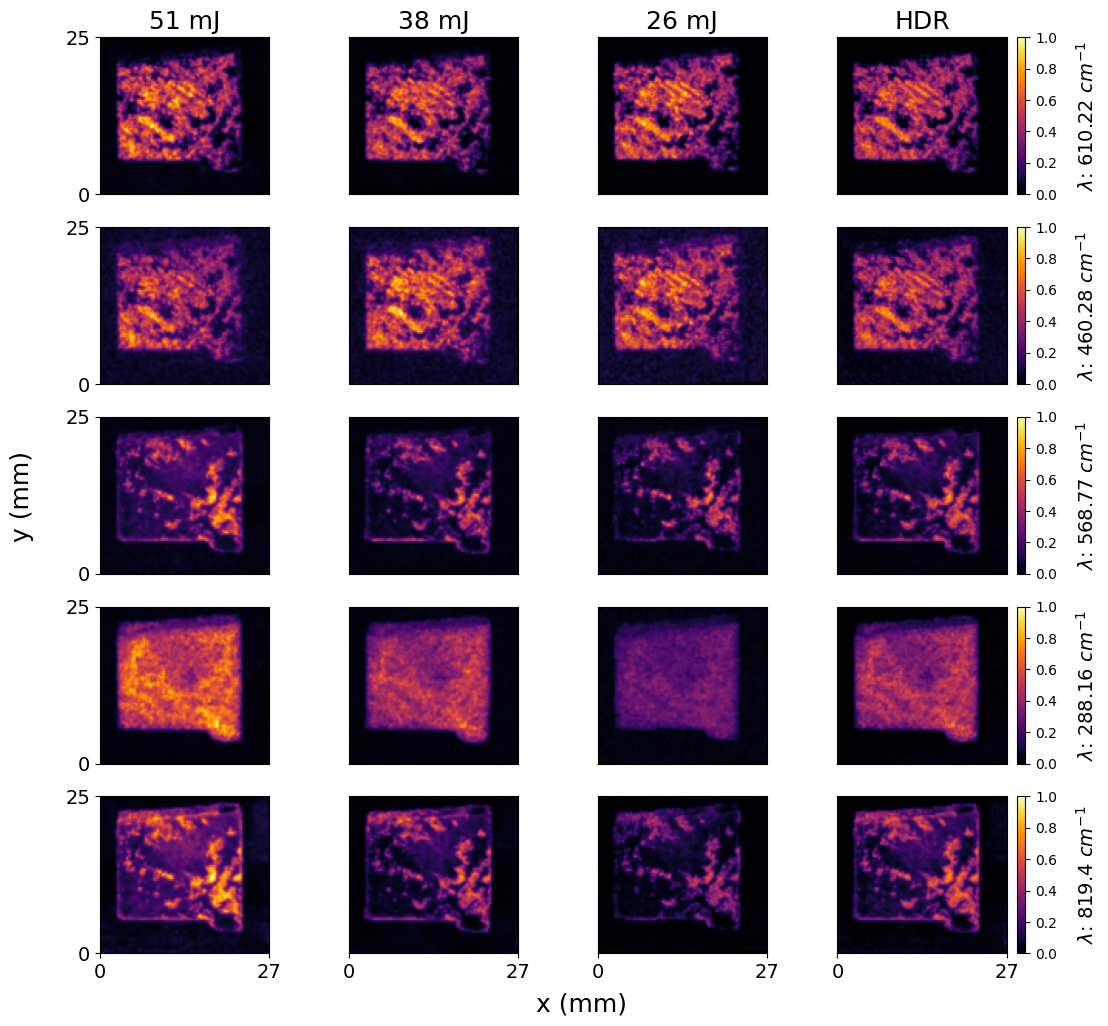

In [20]:
%matplotlib inline

from mpl_toolkits.axes_grid1 import make_axes_locatable
from cmap import Colormap
fig, ax = subplots(5, 4, figsize = (11, 10))

wl = [610.22, 460.28, 568.77, 288.16, 819.40]

# colmap = Colormap('crameri:batlowK').to_mpl()
colmap = 'inferno'


for w in range(len(wl)):
    axs = ax[w, 0]
    if w == 0:
        axs.set_title('51 mJ', fontsize = 18)
    axs.imshow(scaled_pro[0, find_index(wavelengths, wl[w])], extent = (0, 27, 0, 25), cmap = colmap, vmin = 0, vmax = 1)
    axs.set_xticks([])
    axs.set_yticks([])

    axs = ax[w, 1]
    if w == 0:
        axs.set_title('38 mJ', fontsize = 18)
    axs.imshow(scaled_pro[1, find_index(wavelengths, wl[w])], extent = (0, 27, 0, 25), cmap = colmap, vmin = 0, vmax = 1)
    axs.set_xticks([])
    axs.set_yticks([])

    axs = ax[w, 2]
    if w == 0:
        axs.set_title('26 mJ', fontsize = 18)
    axs.imshow(scaled_pro[2, find_index(wavelengths, wl[w])], extent = (0, 27, 0, 25), cmap = colmap, vmin = 0, vmax = 1)
    axs.set_xticks([])
    axs.set_yticks([])

    axs = ax[w, 3]
    if w == 0:
        axs.set_title('HDR', fontsize = 18)
    im = axs.imshow(new_data1[find_index(wavelengths, wl[w])], extent = (0, 27, 0, 25), cmap = colmap, vmin = 0, vmax = 1)
    axs.set_xticks([])
    axs.set_yticks([])
    axs.set_ylabel(r'$\lambda$: ' + f'{wl[w]} ' + r'$cm^{-1}$', fontsize = 14, labelpad = 50)
    divider = make_axes_locatable(axs)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    colorbar(im, cax = cax)
    axs.yaxis.set_label_position("right")

for i in range(ax.shape[0]):
    ax[i, 0].set_yticks([0, 25])
    ax[i, 0].set_yticklabels([0, 25], fontsize = 14)
    
for j in range(ax.shape[1]):
    ax[-1, j].set_xticks([0, 27])
    ax[-1, j].set_xticklabels([0, 27], fontsize = 14)


fig.tight_layout(pad = 1)
fig.supxlabel('x (mm)', fontsize = 18, x = 0.5, y = -0.02)
fig.supylabel('y (mm)', fontsize = 18, y = 0.5, x = -0.02)

# fig.savefig('libs_energies.jpg', dpi = 300)

### Test PSNR

In [336]:
def min_max(img):
    return (img - img.min())/(img.max() - img.min())

def estimate_PSNR(img):
    moi = scaled_pro[0, find_index(wavelengths, 288.16)]
    noise_area = moi < 0.1

    PSNR = 10 * np.log10(1/np.mean(img[noise_area]))
    return PSNR

wl = [610.22, 460.28, 568.77, 288.16, 819.40]

for wvl in wl:
    print(f"Metrics for: {wvl} nm")

    imn = scaled_pro[0, find_index(wavelengths, wvl)]
    imf = min_max(imn)
    print(f"    -Contrast with {51} mJ: {np.sum(abs(laplace(imf))):.2f}")
    print(f"    -PSNR with {51} mJ: {estimate_PSNR(imn):.2f}")
    print("")

    imn = scaled_pro[1, find_index(wavelengths, wvl)]
    imf = min_max(imn)
    print(f"    -Contrast with {38} mJ: {np.sum(abs(laplace(imf))):.2f}")
    print(f"    -PSNR with {38} mJ: {estimate_PSNR(imn):.2f}")
    print("")

    imn = scaled_pro[2, find_index(wavelengths, wvl)]
    imf = min_max(imn)
    print(f"    -Contrast with {26} mJ: {np.sum(abs(laplace(imf))):.2f}")
    print(f"    -PSNR with {26} mJ: {estimate_PSNR(imn):.2f}")
    print("")

    imn = new_data1[find_index(wavelengths, wl[w])]
    imf = min_max(imn)
    print(f"    -Contrast with HDR: {np.sum(abs(laplace(imf))):.2f}")
    print(f"    -PSNR with HDR: {estimate_PSNR(imn):.2f}")
    print("")

Metrics for: 610.22 nm
    -Contrast with 51 mJ: 822.59
    -PSNR with 51 mJ: 16.41

    -Contrast with 38 mJ: 854.01
    -PSNR with 38 mJ: 17.73

    -Contrast with 26 mJ: 845.60
    -PSNR with 26 mJ: 20.54

    -Contrast with HDR: 656.62
    -PSNR with HDR: 21.48

Metrics for: 460.28 nm
    -Contrast with 51 mJ: 728.68
    -PSNR with 51 mJ: 11.32

    -Contrast with 38 mJ: 879.03
    -PSNR with 38 mJ: 11.27

    -Contrast with 26 mJ: 924.85
    -PSNR with 26 mJ: 10.72

    -Contrast with HDR: 656.62
    -PSNR with HDR: 21.48

Metrics for: 568.77 nm
    -Contrast with 51 mJ: 541.63
    -PSNR with 51 mJ: 14.27

    -Contrast with 38 mJ: 635.72
    -PSNR with 38 mJ: 15.17

    -Contrast with 26 mJ: 649.61
    -PSNR with 26 mJ: 15.44

    -Contrast with HDR: 656.62
    -PSNR with HDR: 21.48

Metrics for: 288.16 nm
    -Contrast with 51 mJ: 512.49
    -PSNR with 51 mJ: 15.74

    -Contrast with 38 mJ: 499.19
    -PSNR with 38 mJ: 15.97

    -Contrast with 26 mJ: 651.96
    -PSNR with 26 m

# 3. Raman Load

In [15]:
from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_als_optimized(y, lam, p, niter = 10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [16]:
fpath = "E:/Data/Data_Raman/HDR/Quadrado/"
filename = ["20231211_ 927.h5", "20231211_1046.h5", "20231211_1152.h5"]

raman_spectrums = []
for fname in filename:
    spectrum_raman, wavelengths_raman, exp_properties = Raman_data_loader(fpath + fname)
    raman_spectrums.append(spectrum_raman)
raman_spectrums = np.array(raman_spectrums)

In [17]:
raman_spectrums = raman_spectrums[:, :, :, 31:328]
raman_wavelengths = np.array(wavelengths_raman[31:328])

## 3.1 Preprocess Raman Data -> Baseline Removal | Scale to [0-1] | Normalize to Sum

In [18]:
lam = 1e2
p = 1e-1

processed = np.array(raman_spectrums)

for k in range(0, processed.shape[0]):
    for i in tqdm(range(0, processed.shape[1])):
        for j in range(0, processed.shape[2]):
            spec = 1 * processed[k, i,j, :]
            processed[k,i,j,:] = spec - baseline_als_optimized(spec, lam = lam, p = p, niter = 10)

for sp in range(processed.shape[0]):
    spe = processed[sp].reshape(processed.shape[1]*processed.shape[2], -1)
    norm = np.array([spe[i, :]/np.sum(spe[i, :]) for i in range(0, spe.shape[0])]).reshape(processed.shape[1], processed.shape[2], -1)
    processed[sp] = norm

scaled_pro_raman = []

sg = 0.5

for i in tqdm(range(0, processed.shape[0])):
    # min_max_scaled = np.array([ (pro_data_sum[i, :, :, wv] - pro_data_sum[i].min())/(pro_data_sum[i].max() - pro_data_sum[i].min()) for wv in range(pro_data_sum.shape[-1])])
    min_max_scaled = np.zeros((processed.shape[-1], processed.shape[1], processed.shape[2]))
    for wv in range(processed.shape[-1]):
        gf = gaussian_filter(processed[:, :, :, wv], axes = (1, 2), sigma = sg)
        min_max_scaled[wv] = (gf[i] - gf.min()) / (gf.max() - gf.min())
    scaled_pro_raman.append(min_max_scaled)

scaled_pro_raman = np.array(scaled_pro_raman)[:,:,0:64,0:64]

  0%|          | 0/65 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00,  4.70it/s]


## 3.2 Pyramid Fusion Raman

In [181]:
w_exposedness = gauss(scaled_pro_raman, 0.2, 0.5)

entropy = np.zeros(scaled_pro_raman.shape)
for e in range(entropy.shape[0]):
    for wv in tqdm(range(entropy.shape[1])):
        # entropy[e, wv] = rank.entropy(scaled_pro[e, wv], disk(5))
        entropy[e, wv] = abs(laplace(scaled_pro_raman[e, wv])) + 1e-10


weigths = w_exposedness * entropy
w_sum = np.sum(weigths, axis = 0)
weights_norm = weigths/w_sum

new_data1_raman = np.zeros(scaled_pro_raman.shape[1:])
n_layers = 6

x_padding = 0
y_padding = 0

for j in tqdm(range(weights_norm.shape[1])):
    image_p = add_padding(scaled_pro_raman[:, j], x_padding, y_padding)
    L = laplacian_pyramid(image_p, layers = n_layers)
    weights_p = add_padding(weights_norm[:, j], x_padding, y_padding)
    G = gaussian_pyramid(weights_p, layers = n_layers)
    final_pyra = final_pyramid(L, G)
    pyra_image = get_image(final_pyra)
    new_data1_raman[j, :, :] = pyra_image[x_padding:pyra_image.shape[0]-x_padding, y_padding:pyra_image.shape[1]-y_padding]

100%|██████████| 297/297 [00:01<00:00, 157.21it/s]


Text(-0.02, 0.5, 'y (mm)')

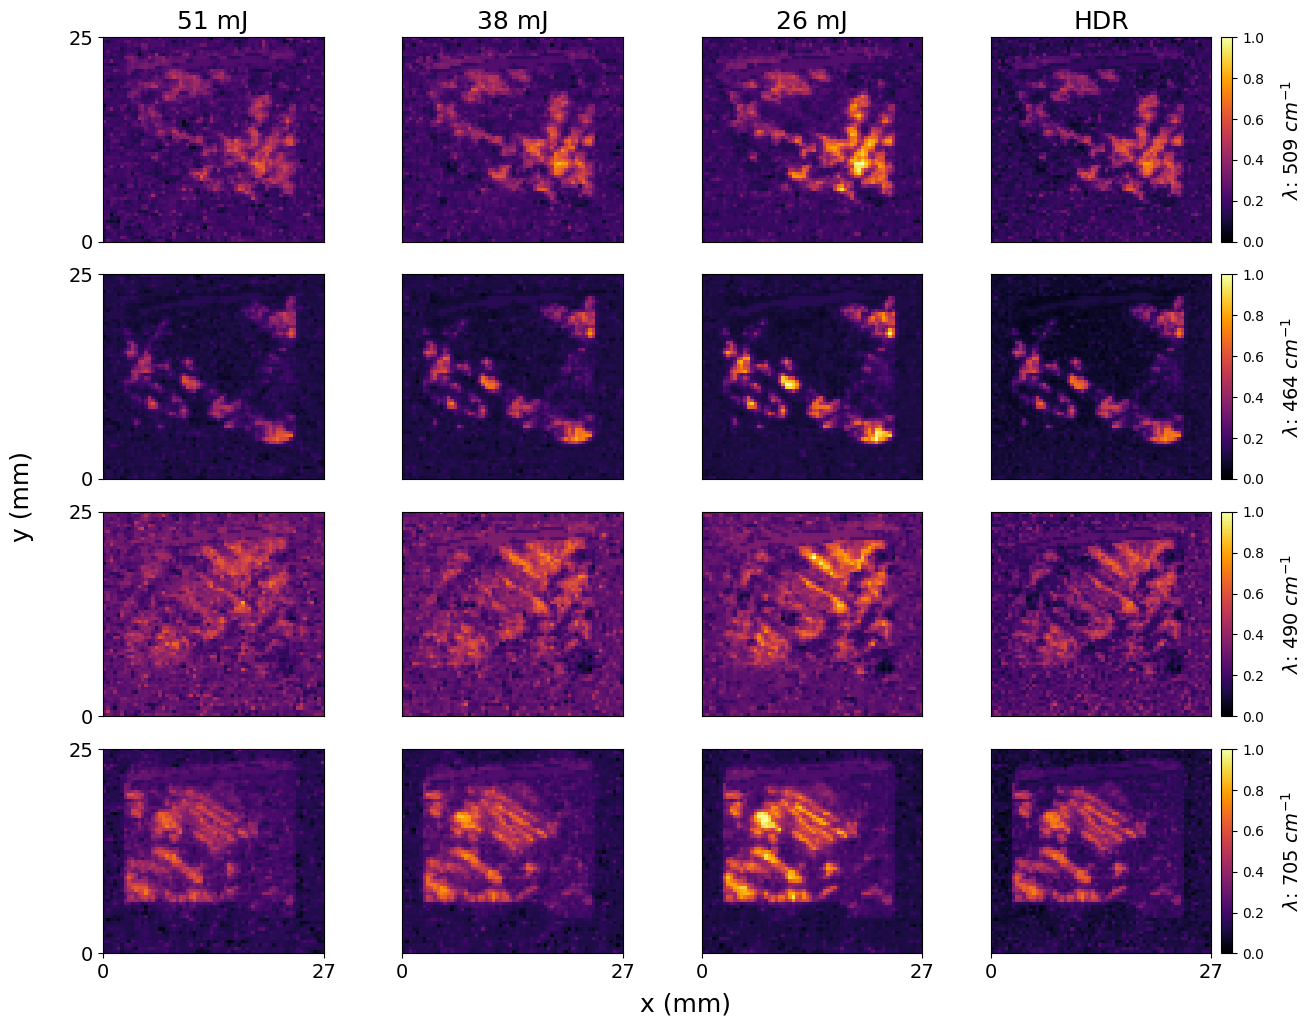

In [271]:
%matplotlib inline

%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = subplots(4, 4, figsize = (13, 10))

wl = [509, 464, 490, 705]


for w in range(len(wl)):
    axs = ax[w, 0]
    if w == 0:
        axs.set_title('51 mJ', fontsize = 18)
    axs.imshow(scaled_pro_raman[0, find_index(raman_wavelengths, wl[w])], extent = (0, 27, 0, 25), cmap = 'inferno', vmin = 0, vmax = 1)
    axs.set_xticks([])
    axs.set_yticks([])

    axs = ax[w, 1]
    if w == 0:
        axs.set_title('38 mJ', fontsize = 18)
    axs.imshow(scaled_pro_raman[1, find_index(raman_wavelengths, wl[w])], extent = (0, 27, 0, 25), cmap = 'inferno', vmin = 0, vmax = 1)
    axs.set_xticks([])
    axs.set_yticks([])

    axs = ax[w, 2]
    if w == 0:
        axs.set_title('26 mJ', fontsize = 18)
    axs.imshow(scaled_pro_raman[2, find_index(raman_wavelengths, wl[w])], extent = (0, 27, 0, 25), cmap = 'inferno', vmin = 0, vmax = 1)
    axs.set_xticks([])
    axs.set_yticks([])

    axs = ax[w, 3]
    if w == 0:
        axs.set_title('HDR', fontsize = 18)
    im = axs.imshow(new_data1_raman[find_index(raman_wavelengths, wl[w])], extent = (0, 27, 0, 25), cmap = 'inferno', vmin = 0, vmax = 1)
    axs.set_xticks([])
    axs.set_yticks([])
    axs.set_ylabel(r'$\lambda$: ' + f'{wl[w]} ' + r'$cm^{-1}$', fontsize = 14, labelpad = 50)
    divider = make_axes_locatable(axs)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    colorbar(im, cax = cax)
    axs.yaxis.set_label_position("right")

for i in range(ax.shape[0]):
    ax[i, 0].set_yticks([0, 25])
    ax[i, 0].set_yticklabels([0, 25], fontsize = 14)
    
for j in range(ax.shape[1]):
    ax[-1, j].set_xticks([0, 27])
    ax[-1, j].set_xticklabels([0, 27], fontsize = 14)


fig.tight_layout(pad = 1)
fig.supxlabel('x (mm)', fontsize = 18, x = 0.5, y = -0.02)
fig.supylabel('y (mm)', fontsize = 18, y = 0.5, x = -0.02)

# fig.savefig('libs_energies.jpg', dpi = 300)

In [335]:
def min_max(img):
    return (img - img.min())/(img.max() - img.min())

def estimate_PSNR(img):

    PSNR = 10*np.log10(1/np.mean(img[52:60, 10:50]))
    return PSNR

wl = [509, 464, 490, 705]

for wvl in wl:
    print(f" Measurement for: {wvl} cm^-1")

    imn = scaled_pro_raman[0, find_index(raman_wavelengths, wvl)]
    imf = min_max(imn)
    print(f"    -{120} mW: {np.sum(abs(laplace(imf))):.2f}")
    print(f"    -PSNR with HDR: {estimate_PSNR(imn):.2f}")

    imn = scaled_pro_raman[1, find_index(raman_wavelengths, wvl)]
    imf = min_max(imn)
    print(f"    -{160} mW: {np.sum(abs(laplace(imf))):.2f}")
    print(f"    -PSNR with HDR: {estimate_PSNR(imn):.2f}")

    imn = scaled_pro_raman[2, find_index(raman_wavelengths, wvl)]
    imf = min_max(imn)
    print(f"    -{240} mW: {np.sum(abs(laplace(imf))):.2f}")
    print(f"    -PSNR with HDR: {estimate_PSNR(imn):.2f}")

    imn = new_data1_raman[find_index(raman_wavelengths, wvl)]
    imf = min_max(imn)
    print(f"    -HDR: {np.sum(abs(laplace(imf))):.2f}")
    print(f"    -PSNR with HDR: {estimate_PSNR(imn):.2f}")
    print("")

 Measurement for: 509 cm^-1
    -120 mW: 669.67
    -PSNR with HDR: 4.07
    -160 mW: 557.79
    -PSNR with HDR: 5.62
    -240 mW: 483.06
    -PSNR with HDR: 7.34
    -HDR: 735.31
    -PSNR with HDR: 5.36

 Measurement for: 464 cm^-1
    -120 mW: 447.84
    -PSNR with HDR: 5.55
    -160 mW: 397.22
    -PSNR with HDR: 7.44
    -240 mW: 359.17
    -PSNR with HDR: 9.19
    -HDR: 483.98
    -PSNR with HDR: 7.32

 Measurement for: 490 cm^-1
    -120 mW: 848.75
    -PSNR with HDR: 3.57
    -160 mW: 847.33
    -PSNR with HDR: 3.34
    -240 mW: 585.24
    -PSNR with HDR: 5.90
    -HDR: 1125.51
    -PSNR with HDR: 2.72

 Measurement for: 705 cm^-1
    -120 mW: 575.76
    -PSNR with HDR: 5.25
    -160 mW: 482.71
    -PSNR with HDR: 7.29
    -240 mW: 428.00
    -PSNR with HDR: 9.10
    -HDR: 671.42
    -PSNR with HDR: 6.49



## 3.3 Align with Final LIBS Pyramid

In [25]:
%load_ext autoreload

In [26]:
%autoreload 2

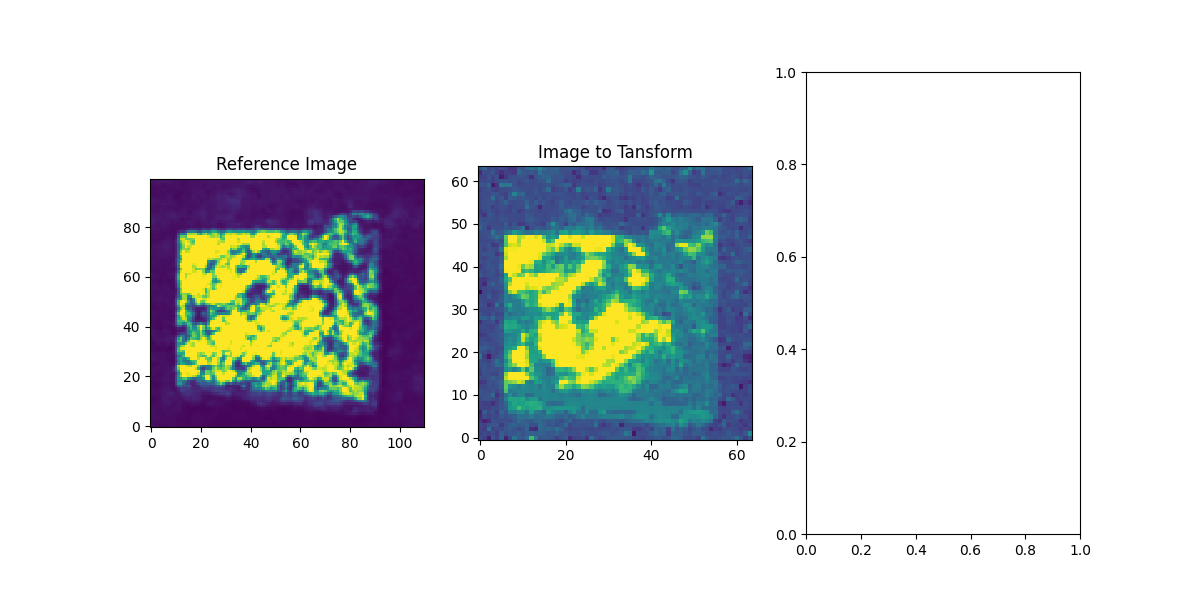

In [184]:
# from transform import *

# raman_map = scaled_pro_raman[2, find_index(raman_wavelengths, 704.5), :, :]
# libs_map = scaled_pro[0, find_index(wavelengths, 610.22), :, :]

# %matplotlib widget
# aligner = align(libs_map, raman_map, lognorm = False, vmax_l = 0.50, vmax_r = 0.5, weigths = 'None', pixel_tol = 1, sig = 0.05)

# 4. Classification

## 4.1 Raman Features

In [225]:
final_mask_raman = np.transpose(new_data1_raman, axes = (1, 2, 0))

minerals = {
    'Petalite':[491.3],
    'Quartz':[463.92],
    'Spodumene':[704.5],
    'Albite':[508.1],
    'Background':[733.1]}

mineral_list = list(minerals.keys())

features_raman = []
radius = 2

for i,mineral in enumerate(mineral_list):
    wn = find_index(raman_wavelengths,minerals[mineral][0])
    new_array = final_mask_raman[:, :, wn-radius : wn+radius].mean(axis = -1)
    features_raman.append( ( new_array - np.min(new_array) ) / (np.max(new_array) - np.min(new_array)))
    
features_raman = np.transpose(np.array(features_raman), axes = (1, 2, 0))
features_raman = features_raman.reshape([features_raman.shape[0]*features_raman.shape[1], features_raman.shape[2]])

initial_mineral_list = mineral_list

In [226]:
features_raman = np.transpose(features_raman, axes = (1, 0))
features_raman = features_raman.reshape(-1, 64, 64)
f_raman = features_raman

## 4.2 LIBS Features

In [227]:
# wl = [460.28, 610.22, 670.76, 288.16, 251.59, 252.82, 568.77, 588.95, 819.40, 237.23, 308.17, 309.25]
wl = [610.22, 288.16, 588.95, 308.17]
features_libs = np.array([new_data1[find_index(wavelengths, wl[w])] for w in range(len(wl))])
libs_f = features_libs

In [228]:
f_raman = []
for i in tqdm(range(5)): 
    aligner.transform(features_raman[i, :, :])
    aligned_map = aligner.new_data
    f_raman.append(aligned_map)
f_raman = np.array(f_raman)

100%|██████████| 5/5 [00:01<00:00,  3.95it/s]


In [229]:
f_raman_cut = np.transpose(f_raman[:, 15:70, 15:70], axes = (1, 2, 0))
f_raman_cut = f_raman_cut.reshape(f_raman_cut.shape[0]*f_raman_cut.shape[1], -1)
f_libs_cut = np.transpose(libs_f[:, 15:70, 15:70], axes = (1, 2, 0))
f_libs_cut = f_libs_cut.reshape(f_libs_cut.shape[0]*f_libs_cut.shape[1], -1)

## 4.3 K-Means Clustering

In [230]:
import sklearn

In [231]:
minerals = {
    'Petalite':[491.3],
    'Quartz':[463.92],
    'Spodumene':[704.5],
    'Albite':[508.1]}

mineral_list = list(minerals.keys())
n_clusters = 4

# Cluster centers already initialized to match those of the predicted features
clusters_init = [[1, 0, 0, 0, 0], 
                 [0, 1, 0, 0, 0],
                 [0, 0, 1, 0, 0],
                 [0, 0, 0, 1, 0]
                ]

model = sklearn.cluster.KMeans(n_clusters=n_clusters, init = np.array(clusters_init), random_state=100)
model.fit(f_raman_cut)
predictions = model.predict(f_raman_cut)

In [232]:
# wl = [460.28, 610.22, 670.76, 288.16, 251.59, 252.82, 568.77, 588.95, 819.40, 237.23, 308.17, 309.25]
wl = [670.76, 288.16, 588.95, 308.17]
######Li       Si       Al     Na


init=np.array([[1, 1, 1, 0],
               [0, 1, 0, 0],
               [1, 1, 1, 0],
               [0, 1, 1, 1]])
model1 = KMeans(n_clusters = 4, init = init)

labels_libs = model1.fit_predict(f_libs_cut)

In [233]:
# labels_libs[labels_libs == 1] = 5
# labels_libs[labels_libs == 2] = 1
# labels_libs[labels_libs == 5] = 2

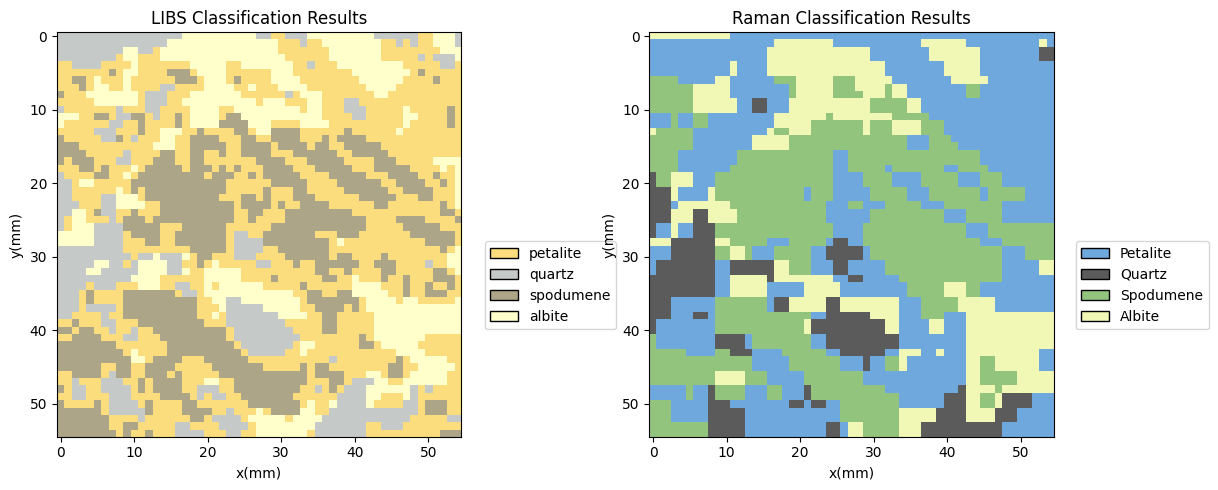

In [234]:
fig, axs = subplots(1, 2, figsize = (12, 5))

ax = axs[0]
nx, ny = 55, 55
colors = ['xkcd:wheat' ,'xkcd:silver','xkcd:stone','xkcd:ecru']
cmp_libs = ListedColormap(colors)
ax.set_xlabel('x(mm)')
ax.set_ylabel('y(mm)')
ax.imshow(labels_libs.reshape(nx, ny)[::, ::], cmap = cmp_libs, interpolation = 'none')
mineral_list2=['petalite','quartz','spodumene','albite']
hls=[]
for color,cluster in zip(colors,mineral_list2):
    patch = mpatches.Patch(color=color, label=cluster,ec='k')
    hls.append(patch)

ax.set_title('LIBS Classification Results')
ax.legend(handles=hls, bbox_to_anchor=(1.4, 0.5))

ax = axs[1]
colors = ['#6fa8dc','#5b5b5b','#93c47d','#F1F7B5']
cmp1 = ListedColormap(colors[:n_clusters])
ax.imshow(predictions.reshape(nx, ny),
           cmap=cmp1,interpolation='nearest')

hls=[]
for color,cluster in zip(colors,mineral_list):
    patch = mpatches.Patch(color=color, label=cluster,ec='k')
    hls.append(patch)

ax.set_title('Raman Classification Results')
ax.legend(handles=hls,bbox_to_anchor=(1.4, 0.5))
ax.set_xlabel(r'x(mm)')
ax.set_ylabel(r'y(mm)')
fig.tight_layout()

# savefig("Images/LIBSvRaman.jpg", dpi = 300)

In [195]:
from sklearn import metrics

libs_confusion_hdr = metrics.confusion_matrix(predictions, labels_libs)

In [196]:
libs_confusion_hdr = np.array(libs_confusion_hdr, dtype = float)
for i in range(libs_confusion_hdr.shape[0]):
    libs_confusion_hdr[i] /= np.sum(libs_confusion_hdr[i])

[Text(0, 0, 'petalite'),
 Text(0, 1, 'quartz'),
 Text(0, 2, 'spodumene'),
 Text(0, 3, 'albite')]

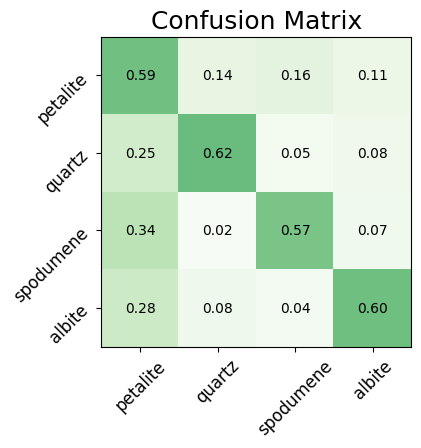

In [198]:
%matplotlib inline
mineral_list2=['petalite','quartz','spodumene','albite']
fig, axs = subplots(1, 1, figsize = (4, 8))
# ax.imshow(libs_confusion, cmap = 'Greens')

ax = axs
ax.set_title('Confusion Matrix', fontsize = 18)
ax.imshow(libs_confusion_hdr, cmap = 'Greens', alpha = 0.8, vmin = 0, vmax = 1)
for i in range(libs_confusion_hdr.shape[0]):
    for j in range(libs_confusion_hdr.shape[1]):
        ax.text(x = j, y = i, s = f'{libs_confusion_hdr[i, j]:.2f}', va = 'center', ha = 'center', size = 'medium')

ax.set_xticks([0, 1, 2, 3])
ax.set_yticks([0, 1, 2, 3])
ax.set_xticklabels(mineral_list2, rotation = 45, fontsize = 12)
ax.set_yticklabels(mineral_list2, fontsize = 12, rotation = 45)

# savefig("Images/LIBSvRaman_confusion.jpg", dpi = 300)

In [199]:
print(f'Classification Performmance: {sum(labels_libs == predictions)/len(predictions):.2f}')

Classification Performmance: 0.59


# 5. Individual Clustering

In [200]:
from sklearn import metrics
cluster_e = []
matrix_conf = []
for energy in range(scaled_pro.shape[0]):
    nx, ny = 55, 55
    wl = [670.76, 288.16, 588.95, 308.17]
    features_libs = np.array([scaled_pro[energy, find_index(wavelengths, wl[w]), :, :] for w in range(len(wl))])

    features_libs = features_libs.reshape(-1, features_libs.shape[1], features_libs.shape[2])

    libs_f = features_libs
    # libs_f = []
    # for i in tqdm(range(4)): 
    #     aligner.transform(features_libs[i, :, :])
    #     aligned_map = aligner.new_data
    #     libs_f.append(aligned_map)
    libs_f = np.array(libs_f)

    colors = ['xkcd:wheat' ,'xkcd:silver','xkcd:stone','xkcd:ecru']
    cmp_libs = ListedColormap(colors)
    
    f_libs_cut = np.transpose(libs_f[:, 15:70, 15:70], axes = (1, 2, 0))
    f_libs_cut = f_libs_cut.reshape(nx*ny, -1)


    init = np.array([[1, 1, 1, 0],
                [0, 1, 0, 0],
               [1, 1, 1, 0],
               [0, 1, 1, 1]])
    model1 = KMeans(n_clusters = 4, init = init)

    labels_libs1 = model1.fit_predict(f_libs_cut)

    libs_confusion = metrics.confusion_matrix(predictions, labels_libs1)
    libs_confusion = np.array(libs_confusion, dtype = float)
    for i in range(libs_confusion.shape[0]):
        libs_confusion[i] /= np.sum(libs_confusion[i])
    
    cluster_e.append(labels_libs1)
    print(f'Classification Performance: {sum(labels_libs1 == labels_libs)/len(labels_libs):.2f}')
    matrix_conf.append(libs_confusion)

Classification Performance: 0.50
Classification Performance: 0.64
Classification Performance: 0.60


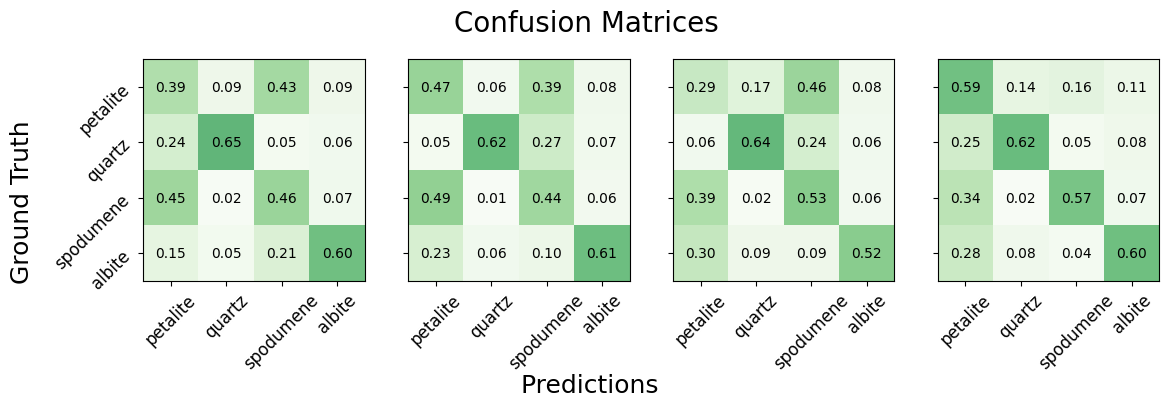

In [204]:
fig, axs = subplots(1, 4, figsize = (12, 4))

fig.suptitle("Confusion Matrices", fontsize = 20)

# ax = axs[0]
# ax.imshow(cluster_e[0].reshape(nx, ny)[::-1, ::], cmap = cmp_libs)
# ax.set_title("51 mJ", fontsize = 16)
# ax.set_xticks([0, 54])
# ax.set_yticks([0, 55])
# ax.set_xticklabels([0, 14], fontsize = 12)
# ax.set_yticklabels([0, 14], fontsize = 12)
# ax.set_xlim(0, 54)
# ax.set_ylim(0, 55)


# ax = axs[1]
# ax.imshow(cluster_e[1].reshape(nx, ny)[::-1, ::], cmap = cmp_libs)
# ax.set_title("38 mJ", fontsize = 16)
# ax.set_xticks([0, 54])
# ax.set_yticks([0, 55])
# ax.set_xticklabels([0, 14], fontsize = 12)
# ax.set_yticklabels([], fontsize = 12)
# ax.set_xlim(0, 54)
# ax.set_ylim(0, 55)


# ax = axs[2]
# ax.imshow(cluster_e[2].reshape(nx, ny)[::-1, ::], cmap = cmp_libs)
# ax.set_title("26 mJ", fontsize = 16)
# ax.set_xticks([0, 54])
# ax.set_yticks([0, 55])
# ax.set_xticklabels([0, 14], fontsize = 12)
# ax.set_yticklabels([], fontsize = 12)
# ax.set_xlim(0, 54)
# ax.set_ylim(0, 55)

# ax = axs[3]
# ax.imshow(labels_libs.reshape(nx, ny)[::-1, ::], cmap = cmp_libs, interpolation = 'none')
# ax.set_title("Multi-Exposure", fontsize = 16)
# ax.set_xticks([0, 54])
# ax.set_yticks([0, 55])
# ax.set_xticklabels([0, 14], fontsize = 12)
# ax.set_yticklabels([], fontsize = 12)
# ax.set_xlim(0, 54)
# ax.set_ylim(0, 55)


# colors = ['xkcd:wheat' ,'xkcd:silver','xkcd:stone','xkcd:ecru']
# cmp_libs = ListedColormap(colors)
# mineral_list2=['petalite','quartz','spodumene','albite']
# hls=[]
# for color,cluster in zip(colors,mineral_list2):
#     patch = mpatches.Patch(color=color, label=cluster,ec='k')
#     hls.append(patch)

# fig.legend(handles=hls,bbox_to_anchor=(0.82, -0.05), ncols = 4, fontsize = 16)

# fig.supxlabel('x (mm)', fontsize = 18)
# fig.supylabel('y (mm)', fontsize = 18)

ax = axs[0]
ax.imshow(matrix_conf[0], cmap = 'Greens', alpha = 0.8, vmin = 0, vmax = 1)
for i in range(matrix_conf[0].shape[0]):
    for j in range(matrix_conf[0].shape[1]):
        ax.text(x = j, y = i, s = f'{matrix_conf[0][i, j]:.2f}', va = 'center', ha = 'center', size = 'medium')

ax.set_xticks([0, 1, 2, 3])
ax.set_yticks([0, 1, 2, 3])
ax.set_xticklabels(mineral_list2, rotation = 45, fontsize = 12)
ax.set_yticklabels(mineral_list2, fontsize = 12, rotation = 45)

ax = axs[1]
ax.imshow(matrix_conf[1], cmap = 'Greens', alpha = 0.8, vmin = 0, vmax = 1)
for i in range(matrix_conf[1].shape[0]):
    for j in range(matrix_conf[1].shape[1]):
        ax.text(x = j, y = i, s = f'{matrix_conf[1][i, j]:.2f}', va = 'center', ha = 'center', size = 'medium')

ax.set_xticks([0, 1, 2, 3])
ax.set_yticks([0, 1, 2, 3])
ax.set_xticklabels(mineral_list2, rotation = 45, fontsize = 12)
ax.set_yticklabels([], fontsize = 12, rotation = 45)

ax = axs[2]
ax.imshow(matrix_conf[2], cmap = 'Greens', alpha = 0.8, vmin = 0, vmax = 1)
for i in range(matrix_conf[2].shape[0]):
    for j in range(matrix_conf[2].shape[1]):
        ax.text(x = j, y = i, s = f'{matrix_conf[2][i, j]:.2f}', va = 'center', ha = 'center', size = 'medium')

ax.set_xticks([0, 1, 2, 3])
ax.set_yticks([0, 1, 2, 3])
ax.set_xticklabels(mineral_list2, rotation = 45, fontsize = 12)
ax.set_yticklabels([], fontsize = 12, rotation = 45)

ax = axs[3]
ax.imshow(libs_confusion_hdr, cmap = 'Greens', alpha = 0.8, vmin = 0, vmax = 1)
for i in range(libs_confusion_hdr.shape[0]):
    for j in range(libs_confusion_hdr.shape[1]):
        ax.text(x = j, y = i, s = f'{libs_confusion_hdr[i, j]:.2f}', va = 'center', ha = 'center', size = 'medium')

ax.set_xticks([0, 1, 2, 3])
ax.set_yticks([0, 1, 2, 3])
ax.set_xticklabels(mineral_list2, rotation = 45, fontsize = 12)
ax.set_yticklabels([], fontsize = 12, rotation = 45)

fig.supxlabel('\n Predictions', fontsize = 18)
fig.supylabel('Ground Truth', fontsize = 18)

fig.tight_layout()

# savefig("Images/LIBS_matrices_all.jpg", dpi = 300)

# E. Extra attempt at Alignment

Text(0.5, 1.0, 'LIBS 5951')

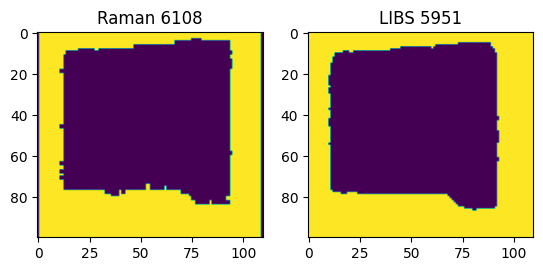

In [193]:
%matplotlib inline

from skimage.transform import resize
from skimage.morphology import area_closing

fig, axs = subplots(1, 2)

raman_al = np.invert(area_closing(np.invert(np.array(scaled_pro_raman[0, find_index(raman_wavelengths, 733.1)] > 0.1)), area_threshold = 12))
libs_al = np.array(scaled_pro[0, find_index(wavelengths, 288.16)] < 0.1)


def area_zeros(img):
    return np.sum(img == 0)

def apply_scale(img, scale):
    return resize(img, (int(img.shape[0]*scale), int(img.shape[1]*scale)), order = 0)

def cut_amount(cut):
    if cut%2 != 0:
        return int(np.ceil(cut/2)), int(np.floor(cut/2))
    else:
        return cut//2, cut//2


scale_factor = np.linspace(1, 3, 1000)
area_libs = area_zeros(libs_al)

optim = []

for scale in scale_factor:
    raman_scal = apply_scale(raman_al, scale)
    area_raman = area_zeros(raman_scal)
    optim.append(area_libs - area_raman)

op_scale = scale_factor[np.argmin(np.abs(optim))]
raman_al = apply_scale(raman_al, op_scale)

#### Same shape ####
x_cut, y_cut = np.array(raman_al.shape) - np.array(libs_al.shape)

x_r, x_l = cut_amount(x_cut)
y_r, y_l = cut_amount(y_cut)

if (x_r >= 0) or (x_l >= 0):
    raman_al = raman_al[x_r:-x_l]
else:
    raman_al = np.pad(raman_al, ((-x_l, -x_r), (0, 0)))

if (y_r >= 0) or (y_l >= 0):
    raman_al = raman_al[:, y_l:-y_r]
else:
    raman_al = np.pad(raman_al, ((0, 0), (-y_l, -y_r)))

ax = axs[0]
ax.imshow(raman_al)
ax.set_title(f"Raman {area_zeros(raman_al)}")

ax = axs[1]
ax.imshow(libs_al)
ax.set_title(f"LIBS {area_zeros(libs_al)}")

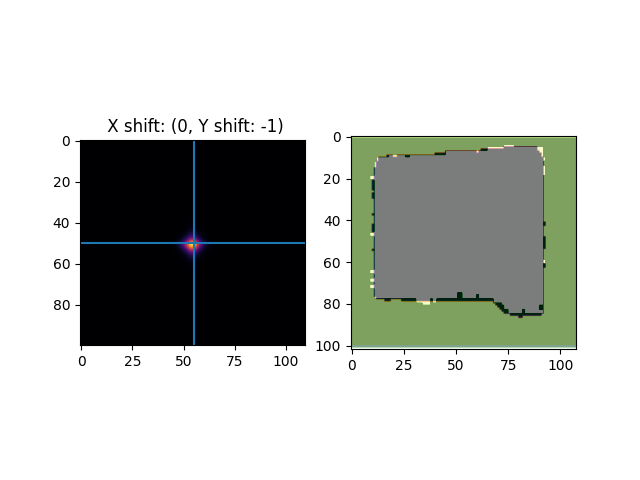

In [189]:
from scipy.signal import correlate

w_t = 819.4

im1 = np.array(libs_al, dtype = float)
im2 = np.array(raman_al, dtype = float)

translation = correlate(im1, im2, mode = 'same')**10

%matplotlib widget
fig, axs = subplots(1, 2)

cx = scaled_pro.shape[-2]//2
cy = scaled_pro.shape[-1]//2

shift_x = -(cx - np.where(translation == translation.max())[0][0])
shift_y = -(cy - np.where(translation == translation.max())[1][0])

ax = axs[0]
ax.set_title(f' X shift: ({shift_x}, ' 
             f'Y shift: {shift_y})')
ax.imshow(abs(translation), cmap = 'inferno')
ax.axhline(scaled_pro.shape[-2]//2)
ax.axvline(scaled_pro.shape[-1]//2)

ax = axs[1]
ax.imshow(im1, cmap = 'inferno')
ax.imshow(np.roll(im2, (shift_x, shift_y), axis = (0, 1)), alpha = 0.5, cmap = 'Greens', vmax = 0.2)

## LIXO

(0.0, 110.0, 100.0, 0.0)

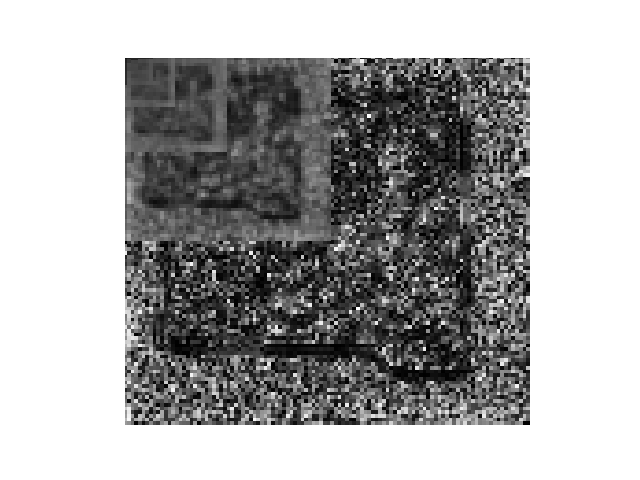

In [114]:
visual = np.zeros(scaled_pro.shape[2:])
x_padding = 14
y_padding = 9
n_layers = 6

image_p = add_padding(scaled_pro[:, find_index(wavelengths, 568.77)], x_padding, y_padding)
L = laplacian_pyramid(image_p, layers = n_layers)
weights_p = add_padding(weights_norm[:, find_index(wavelengths, 568.77)], x_padding, y_padding)
G = gaussian_pyramid(weights_p, layers = n_layers)
final_pyra = final_pyramid(L, G)
pyra_image = get_image(final_pyra)
visual[:, :] = pyra_image[x_padding:pyra_image.shape[0]-x_padding, y_padding:pyra_image.shape[1]-y_padding]
fig, ax = subplots()

ene = 2

for lay in range(L.shape[1]):
    toshow = G[ene, lay][::, ::]
    ex = lay + 1
    ax.imshow(toshow[x_padding//(2**lay):toshow.shape[0]-x_padding//(2**lay),y_padding//(2**lay):toshow.shape[1]-y_padding//(2**lay)], 
              origin = 'upper', cmap  = 'gray', vmin = 0, vmax = 1)
    # ax.imshow(visual, cmap = 'inferno', vmin = 0, vmax = 1)
ax.set_xlim(0, visual.shape[1])
ax.set_ylim(visual.shape[0], 0)
axis('off')

# savefig(f"Images/hdr.jpg", dpi = 300)

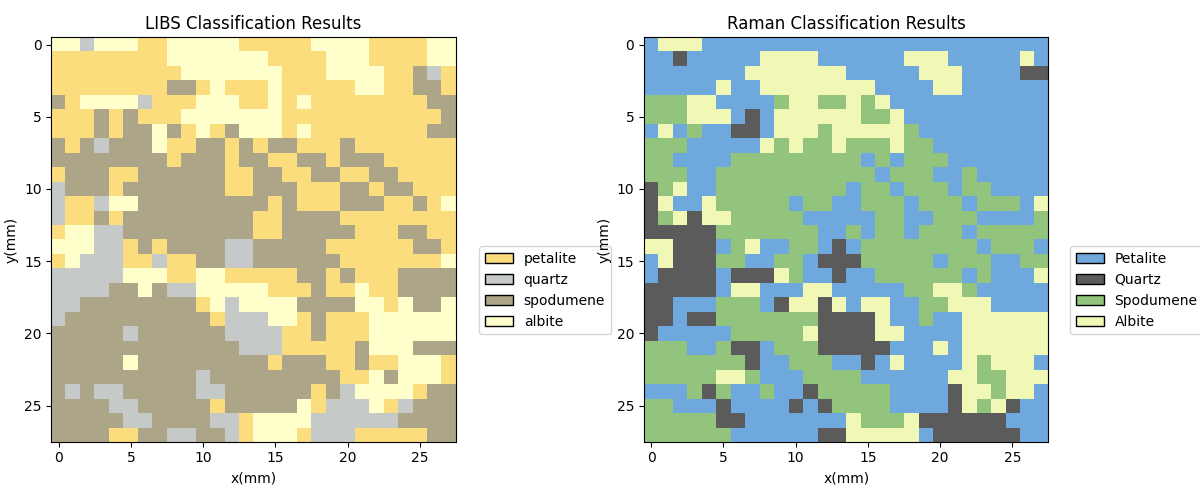

In [ ]:
fig, axs = subplots(1, 2, figsize = (12, 5))

ax = axs[0]
nx, ny = 55, 55
colors = ['xkcd:wheat' ,'xkcd:silver','xkcd:stone','xkcd:ecru']
cmp_libs = ListedColormap(colors)
ax.set_xlabel('x(mm)')
ax.set_ylabel('y(mm)')
ax.imshow(downscaled_image[::, ::], cmap = cmp_libs, interpolation = 'none')
mineral_list2=['petalite','quartz','spodumene','albite']
hls=[]
for color,cluster in zip(colors,mineral_list2):
    patch = mpatches.Patch(color=color, label=cluster,ec='k')
    hls.append(patch)

ax.set_title('LIBS Classification Results')
ax.legend(handles=hls, bbox_to_anchor=(1.4, 0.5))

ax = axs[1]
colors = ['#6fa8dc','#5b5b5b','#93c47d','#F1F7B5']
cmp1 = ListedColormap(colors[:n_clusters])
ax.imshow(predictions.reshape(nx, ny)[::2, ::2],
           cmap=cmp1,interpolation='nearest')

hls=[]
for color,cluster in zip(colors,mineral_list):
    patch = mpatches.Patch(color=color, label=cluster,ec='k')
    hls.append(patch)

ax.set_title('Raman Classification Results')
ax.legend(handles=hls,bbox_to_anchor=(1.4, 0.5))
ax.set_xlabel(r'x(mm)')
ax.set_ylabel(r'y(mm)')
fig.tight_layout()

# savefig("Images/LIBSvRaman.jpg", dpi = 300)

In [ ]:
from scipy import stats

def calculate_mode(pixel, neighbors):
    values = np.concatenate((neighbors.flatten(), [pixel]))
    mode = stats.mode(values)[0]
    return mode

def downscale_image(image):
    return image[::2, ::2]

image = labels_libs.reshape(nx, ny)
height, width = image.shape
mode_image = np.zeros((height, width))

for y in range(height):
    for x in range(width):
        neighbors_y = [max(0, y-1), y, min(height-1, y+1)]
        neighbors_x = [max(0, x-1), x, min(width-1, x+1)]
        neighbors = image[neighbors_y[0]:neighbors_y[2]+1, neighbors_x[0]:neighbors_x[2]+1]

        mode_image[y, x] = calculate_mode(image[y, x], neighbors)

downscaled_image = downscale_image(mode_image)

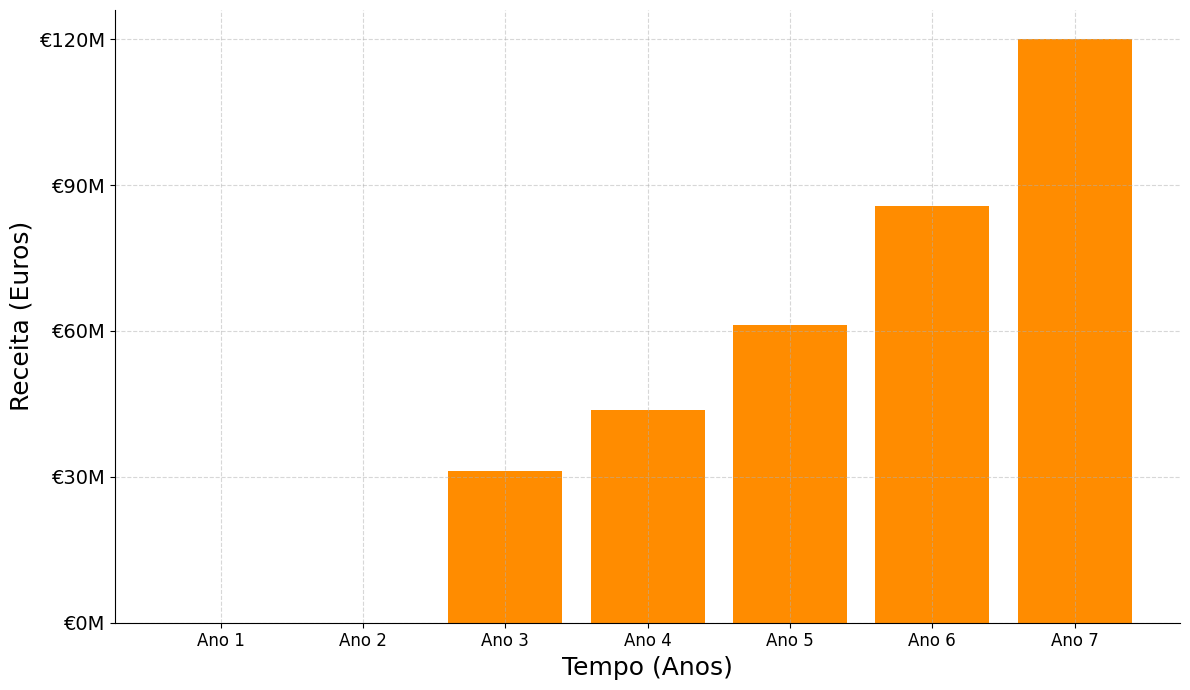

In [331]:
# Correctly defining and recalculating unit sales and revenues for the extended forecast period
casual_total_population = 5000000  # Total number of casual cyclists
professional_total_population = 12000  # Total number of professional cyclists
professional_adoption_rates = [0, 0, 0.025] + [0.025*(1.4**i) for i in range(1, 5)]
# professional_adoption_rates = [0, 0, 0.025, 0.05, 0.1, 0.2, 0.4]
casual_adoption_rates = [0, 0, 0.025] + [0.025*(1.4**i) for i in range(1, 5)]
price_casual_updated = 250
price_professional_updated = 350
years_extended = np.arange(1, 8)


%matplotlib inline
# Recalculating unit sales using the updated prices
casual_units_extended = [rate * casual_total_population for rate in casual_adoption_rates]
professional_units_extended = [rate * professional_total_population for rate in professional_adoption_rates]

# Recalculating revenues
revenue_casual_extended = [units * price_casual_updated for units in casual_units_extended]
revenue_professional_extended = [units * price_professional_updated for units in professional_units_extended]
total_revenue_extended = [x + y for x, y in zip(revenue_casual_extended, revenue_professional_extended)]

# Create the bar chart for the extended period
fig, ax = subplots(figsize=(12, 7))
ax.bar(years_extended, total_revenue_extended, color='darkorange')

# Customize the graph
ax.set_xticks(years_extended)
max_revenue = max(total_revenue_extended)
step_size = max_revenue / 4 
ax.set_xticklabels([f"Ano {year}" for year in years_extended], fontsize=12)
ax.set_yticks(range(0, int(max_revenue) + 1, int(step_size)))
ax.set_yticklabels(['€{:.0f}M'.format(i/1000000) for i in range(0, int(max_revenue) + 1, int(step_size))], fontsize=14)
ax.set_xlabel("Tempo (Anos)", fontsize = 18)
ax.set_ylabel("Receita (Euros)", fontsize = 18)
ax.grid(True, linestyle = '--', alpha = 0.5)
ax.spines[['right', 'top']].set_visible(False)

fig.tight_layout()